# What You're Aiming For
In this checkpoint, we are going to work on the 'Credit Card Dataset for Clustering' dataset provided by Kaggle.

Dataset description : This dataset was derived and simplified for learning purposes. It includes usage behaviour of about 9000 active credit card holders during 6 months period. This case requires to develop a customer segmentation to define marketing strategy.

In [5]:
# import all necessary libraries
import numpy as np
import pandas as pd

# for visuals
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# ggplot style sheet
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

In [6]:
# read and import file
df = pd.read_csv("Credit_card_dataset.csv")
df

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,C10001,0.818182,95.40,201.802084,1000.0,0.000000
1,C10002,0.909091,0.00,4103.032597,7000.0,6442.945483
2,C10003,1.000000,773.17,622.066742,7500.0,0.000000
3,C10004,0.636364,1499.00,0.000000,7500.0,205.788017
4,C10005,1.000000,16.00,678.334763,1200.0,0.000000
...,...,...,...,...,...,...
8945,C19186,1.000000,291.12,325.594462,1000.0,0.000000
8946,C19187,1.000000,300.00,275.861322,1000.0,0.000000
8947,C19188,0.833333,144.40,81.270775,1000.0,0.000000
8948,C19189,0.833333,0.00,52.549959,500.0,36.558778


# Data Inspection

In [7]:
df.shape

(8950, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CUST_ID            8950 non-null   object 
 1   BALANCE_FREQUENCY  8950 non-null   float64
 2   PURCHASES          8950 non-null   float64
 3   PAYMENTS           8950 non-null   float64
 4   CREDIT_LIMIT       8949 non-null   float64
 5   CASH_ADVANCE       8950 non-null   float64
dtypes: float64(5), object(1)
memory usage: 419.7+ KB


In [9]:
# check for duplicates
df.duplicated().sum()

0

In [10]:
# check for missing values
df.isnull().sum()

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         1
CASH_ADVANCE         0
dtype: int64

In [11]:
#  row where the CREDIT_LIMIT column has missing values.
missing_credit_limit_rows = df[df['CREDIT_LIMIT'].isnull()]
missing_credit_limit_rows

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
5203,C15349,0.166667,0.0,9.040017,NaN,186.853063


In [12]:
DF = df.dropna(subset=['CREDIT_LIMIT'], inplace=False)
DF

,CUST_ID,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,C10001,0.818182,95.40,201.802084,1000.0,0.000000
1,C10002,0.909091,0.00,4103.032597,7000.0,6442.945483
2,C10003,1.000000,773.17,622.066742,7500.0,0.000000
3,C10004,0.636364,1499.00,0.000000,7500.0,205.788017
4,C10005,1.000000,16.00,678.334763,1200.0,0.000000
...,...,...,...,...,...,...
8945,C19186,1.000000,291.12,325.594462,1000.0,0.000000
8946,C19187,1.000000,300.00,275.861322,1000.0,0.000000
8947,C19188,0.833333,144.40,81.270775,1000.0,0.000000
8948,C19189,0.833333,0.00,52.549959,500.0,36.558778


We have one missing value in one column and it won't significantly impact my analysis, dropping the row is a reasonable option. It's a straightforward approach that avoids the complexity of imputation and modeling. 

In [13]:
DF.isnull().sum()

CUST_ID              0
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         0
CASH_ADVANCE         0
dtype: int64

In [14]:
# Checking for outliers

# Extract the numerical columns from the dataset
num_vars = DF.select_dtypes(include=['int64', 'float64'])

# Calculate IQR for each numerical feature
Q1 = num_vars.quantile(0.25)
Q3 = num_vars.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers for each numerical feature
outliers_count = ((num_vars < lower_bound) | (num_vars > upper_bound))
outliers_count = outliers_count.sum()

# Display the number of outliers in a table
print("Number of outliers for each column before handling:")
print(outliers_count)


Number of outliers for each column before handling:
BALANCE_FREQUENCY    1492
PURCHASES             808
PAYMENTS              808
CREDIT_LIMIT          248
CASH_ADVANCE         1030
dtype: int64


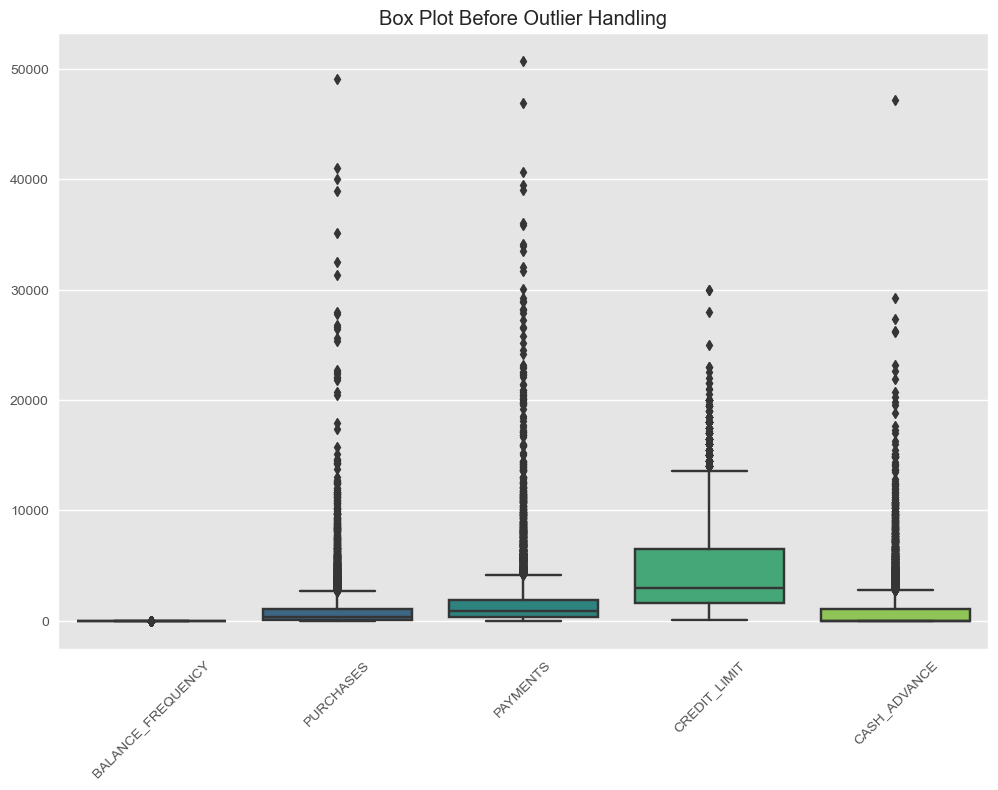

In [15]:
#Box plot before handling outliers
num_vars = DF.select_dtypes(include=['int64', 'float64'])

# Create a box plot for each numerical column before handling outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=num_vars, palette='viridis')
plt.title('Box Plot Before Outlier Handling')
plt.xticks(rotation=45)
plt.show()


In [16]:
#Skewness of each column
from scipy.stats import skew

columns_to_check = ['BALANCE_FREQUENCY', 'PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'CASH_ADVANCE']

for column in columns_to_check:
    skewness = skew(DF[column])
    print(f"Skewness for {column}: {skewness}")

Skewness for BALANCE_FREQUENCY: -2.023853933829657
Skewness for PURCHASES: 8.14260420160155
Skewness for PAYMENTS: 5.906474779191358
Skewness for CREDIT_LIMIT: 1.522208803328015
Skewness for CASH_ADVANCE: 5.165457444186707


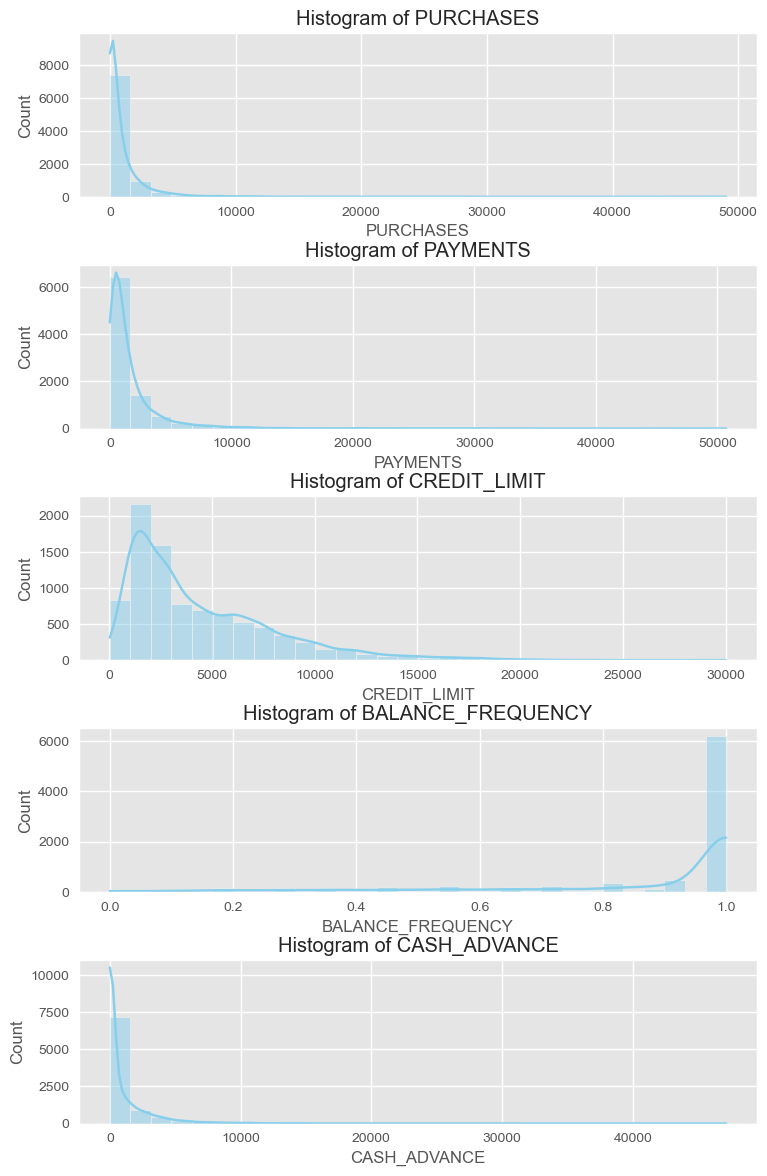

In [17]:
# Checking the distribution of each column
# List of variables to visualize
variables_to_visualize = ['PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'BALANCE_FREQUENCY', 'CASH_ADVANCE']

# Set up subplots
fig, axes = plt.subplots(nrows=len(variables_to_visualize), ncols=1, figsize=(8, 12))
fig.tight_layout(pad=3.0)  # Adjust the padding between subplots

# Create histograms for each variable
for i, variable in enumerate(variables_to_visualize):
    sns.histplot(df[variable], kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Histogram of {variable}')

plt.show()


In [18]:
# Handling outliers

# Extract the numerical columns from the dataset
num_vars = DF.select_dtypes(include=['int64', 'float64'])

# Calculate IQR for each numerical feature
Q1 = num_vars.quantile(0.25)
Q3 = num_vars.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Handle outliers for each numerical feature
df_no_outliers = num_vars.apply(lambda x: x.clip(lower=lower_bound[x.name], upper=upper_bound[x.name]))

# Display the number of outliers for each numerical feature after handling
outliers_count_after_handling = ((df_no_outliers < lower_bound) | (df_no_outliers > upper_bound))
outliers_count_after_handling = outliers_count_after_handling.sum()

# Display the number of outliers in a table after handling
print("Number of outliers for each column after handling:")
print(outliers_count_after_handling)


Number of outliers for each column after handling:
BALANCE_FREQUENCY    0
PURCHASES            0
PAYMENTS             0
CREDIT_LIMIT         0
CASH_ADVANCE         0
dtype: int64


In [19]:
#Confirming Shape after handling outliers
df.shape

(8950, 6)

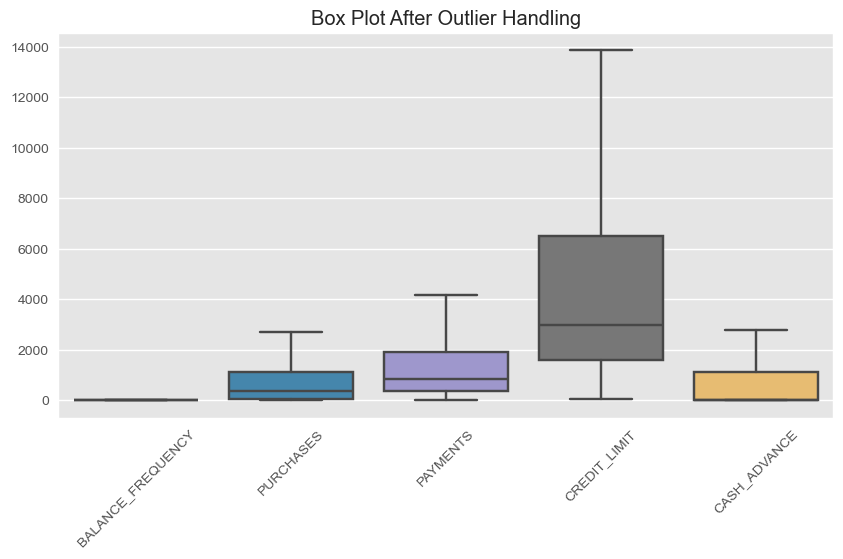

In [20]:
# Box plot after handling outliers
# Assuming df_no_outliers is the DataFrame after handling outliers
num_vars_no_outliers = df_no_outliers

# Create a box plot for each numerical column after handling outliers
plt.figure(figsize=(10, 5))
sns.boxplot(data=num_vars_no_outliers)
plt.title('Box Plot After Outlier Handling')
plt.xticks(rotation=45)
plt.show()

# Feature Selection

In [21]:
# Using the drop() method
Used_df = DF.drop(columns= 'CUST_ID')
Used_df

,BALANCE_FREQUENCY,PURCHASES,PAYMENTS,CREDIT_LIMIT,CASH_ADVANCE
0,0.818182,95.40,201.802084,1000.0,0.000000
1,0.909091,0.00,4103.032597,7000.0,6442.945483
2,1.000000,773.17,622.066742,7500.0,0.000000
3,0.636364,1499.00,0.000000,7500.0,205.788017
4,1.000000,16.00,678.334763,1200.0,0.000000
...,...,...,...,...,...
8945,1.000000,291.12,325.594462,1000.0,0.000000
8946,1.000000,300.00,275.861322,1000.0,0.000000
8947,0.833333,144.40,81.270775,1000.0,0.000000
8948,0.833333,0.00,52.549959,500.0,36.558778


The customer_ID column dropped because it isn't intricate for the insight we want to get

# Hierarchical (Agglomerative) Clustering

In [22]:
selected_features = ['CREDIT_LIMIT','PURCHASES' ]
X = Used_df[selected_features]


# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hierarchical clustering
agg_cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agg_labels = agg_cluster.fit_predict(X_scaled)


We are focusing our segmentation or clustering soley on both CREDIT_LIMIT and PURCHASES based on the instruction

In [23]:
# Agglomerative label
agglomerative=pd.DataFrame(agg_labels)
print(agglomerative[0].value_counts())

0
1    4906
3    2498
0     894
4     627
2      24
Name: count, dtype: int64


# Agglomerative cluster plot

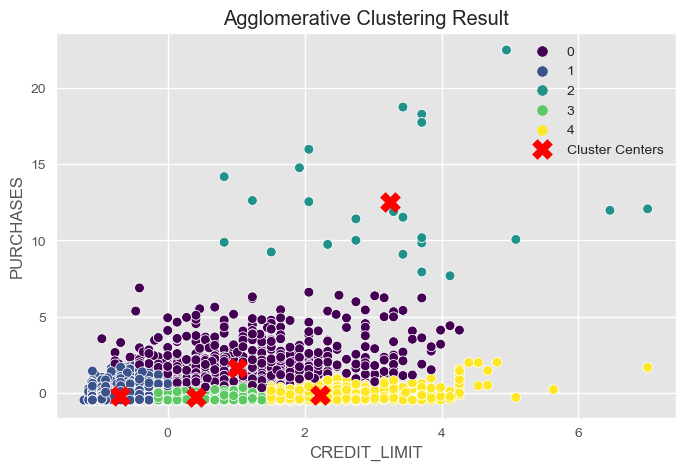

In [24]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=agg_labels, palette='viridis', s=50)
plt.title('Agglomerative Clustering Result')
plt.xlabel('CREDIT_LIMIT')
plt.ylabel('PURCHASES')
plt.legend(title='Cluster')

# Calculate and plot cluster centers
cluster_centers = []
for cluster_label in np.unique(agg_labels):
    cluster_points = X_scaled[agg_labels == cluster_label]
    cluster_center = np.mean(cluster_points, axis=0)
    cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)

plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=200, c='red', marker='X', label='Cluster Centers')
plt.legend()

plt.show()

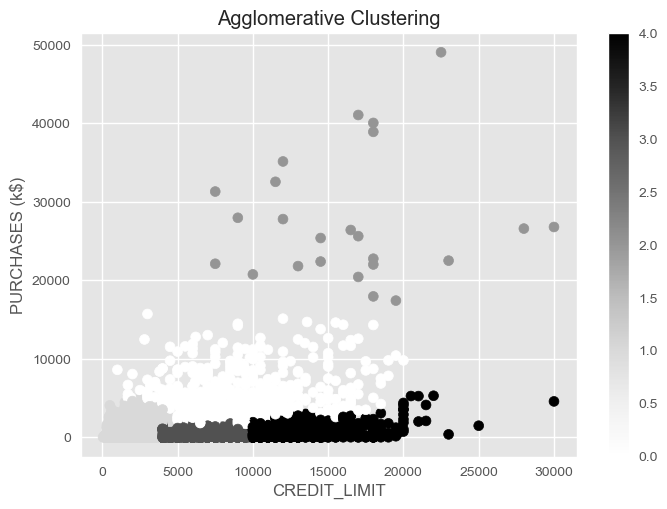

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(Used_df['CREDIT_LIMIT'], Used_df['PURCHASES'], c=agglomerative[0], s=50)
ax.set_title("Agglomerative Clustering")
ax.set_xlabel("CREDIT_LIMIT")
ax.set_ylabel("PURCHASES (k$)")
plt.colorbar(scatter)

# Agglomerative Cluster Interpretation
* Customers in green: Customers that seem to make high purchases of value above their credit limit. We can call them the extravagants.
* Customers in purple: Customers that seem to make average purchases of value below or above above their credit limit.
* Customers in yellow: Customers that seem to make low purchases of value that way below their credit limit. We can call them the cheap ones.
* Customers in blue: Customers that seem to make low purchases of value below or within their credit limit.
* Customers in light green: Customers that seem to make low purchases of value below their credit limit. They are careful customers.

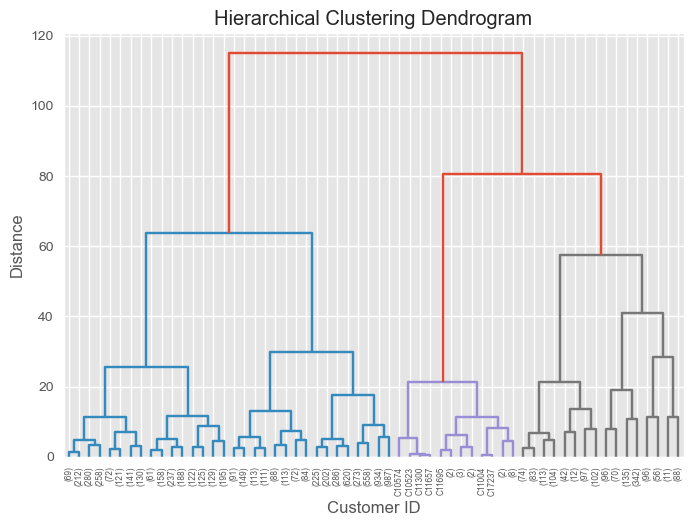

In [26]:
# Plot hierarchical clustering dendrogram
linkage_matrix = linkage(X_scaled, 'ward')
dendrogram(linkage_matrix, p=5, truncate_mode='level', orientation='top', labels=DF['CUST_ID'].tolist())
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer ID')
plt.ylabel('Distance')
plt.show()

# K-means clustering

In [27]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans_labels = kmeans.fit_predict(X_scaled)


# Get cluster centers in the original scale

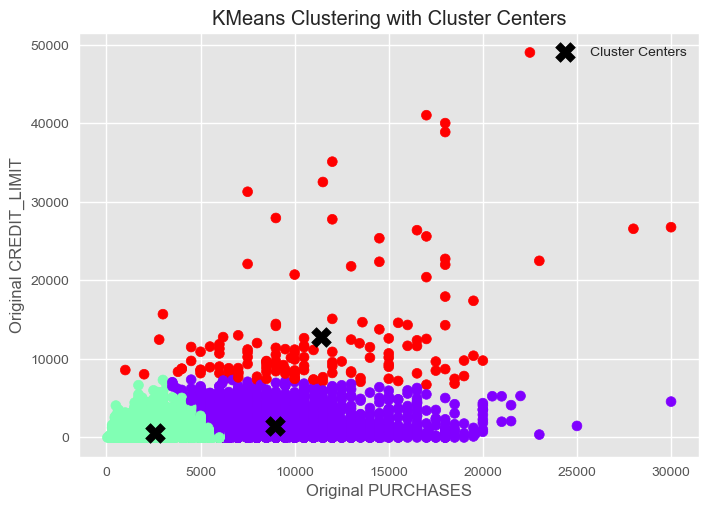

In [28]:
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=kmeans_labels, s=50, cmap="rainbow")
plt.scatter(cluster_centers_original[:, 0], cluster_centers_original[:, 1], c='black', marker='X', s=200, label='Cluster Centers')
plt.xlabel('Original PURCHASES')
plt.ylabel('Original CREDIT_LIMIT')
plt.title('KMeans Clustering with Cluster Centers')
plt.legend()
plt.show()

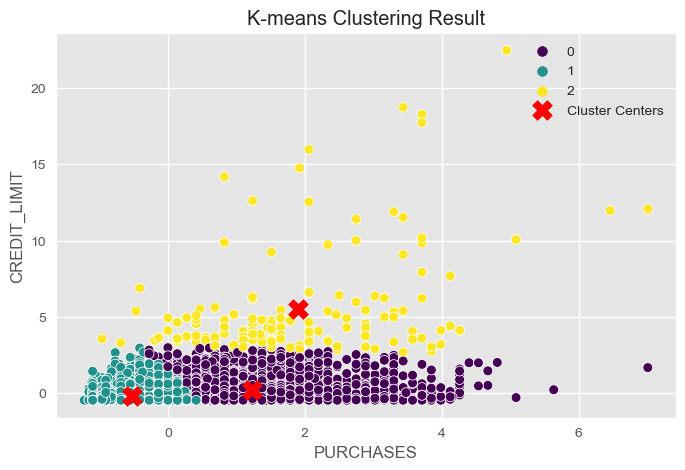

In [29]:
# Scatter plot using seaborn
plt.figure(figsize=(8, 5))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis', s=50)
plt.title('K-means Clustering Result')
plt.xlabel('PURCHASES')
plt.ylabel('CREDIT_LIMIT')
plt.legend(title='Cluster')

# Add cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Cluster Centers')
plt.legend()

plt.show()

# Finding the optimum K-values using the 'elbow method'

In [2]:
!pip install yellowbrick

   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   ---------------------------------------- 0.0/282.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/282.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/282.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/282.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/282.6 kB ? eta -:--:--
  

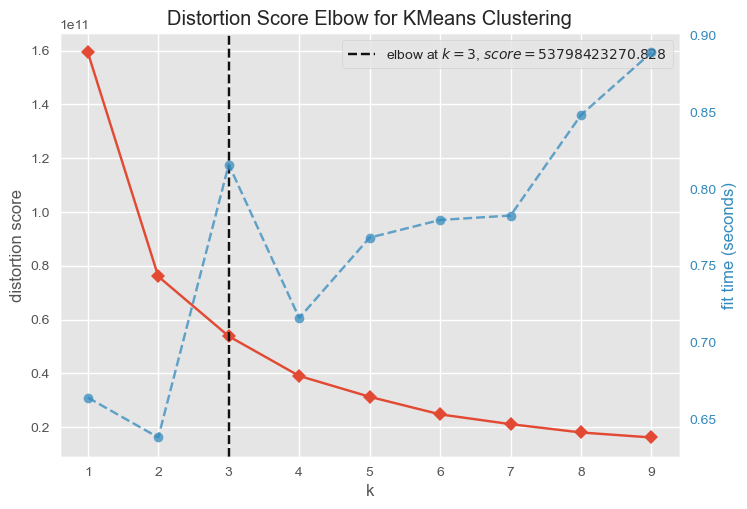

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

# Assuming 'Used_df' is your DataFrame
selected_features = ['CREDIT_LIMIT', 'PURCHASES']
X = Used_df[selected_features].values  # Extract values directly from DataFrame

# Instantiate the KMeans model
model = KMeans()

# Use the elbow method to find the optimal value of K
visualizer = KElbowVisualizer(model, k=(1, 10))
visualizer.fit(X)
visualizer.show()


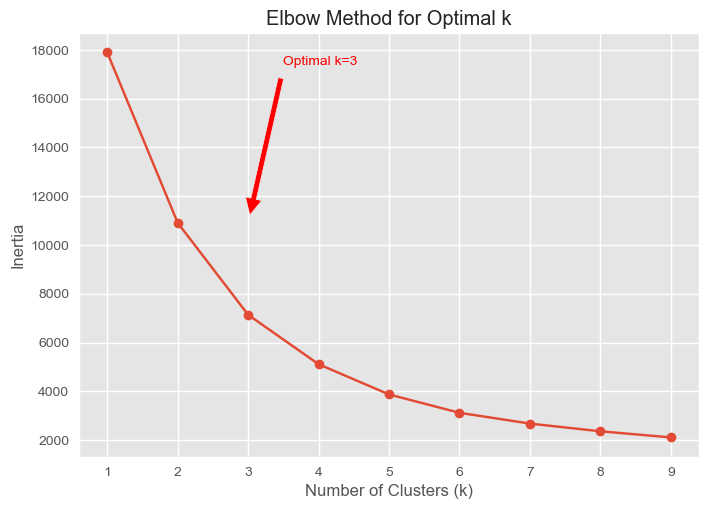

Optimal number of clusters based on Elbow Method: 3


In [32]:
k_values = range(1, 10)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

# Annotate the optimal number of clusters based on the elbow method
optimal_k_elbow = 3

plt.annotate(f'Optimal k={optimal_k_elbow}', xy=(optimal_k_elbow, inertia[optimal_k_elbow - 2]),
             xytext=(optimal_k_elbow + 0.5, max(inertia) - 500),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=10, color='red')

plt.show()

print("Optimal number of clusters based on Elbow Method:", optimal_k_elbow)


# Visualising optimal cluster point on graph

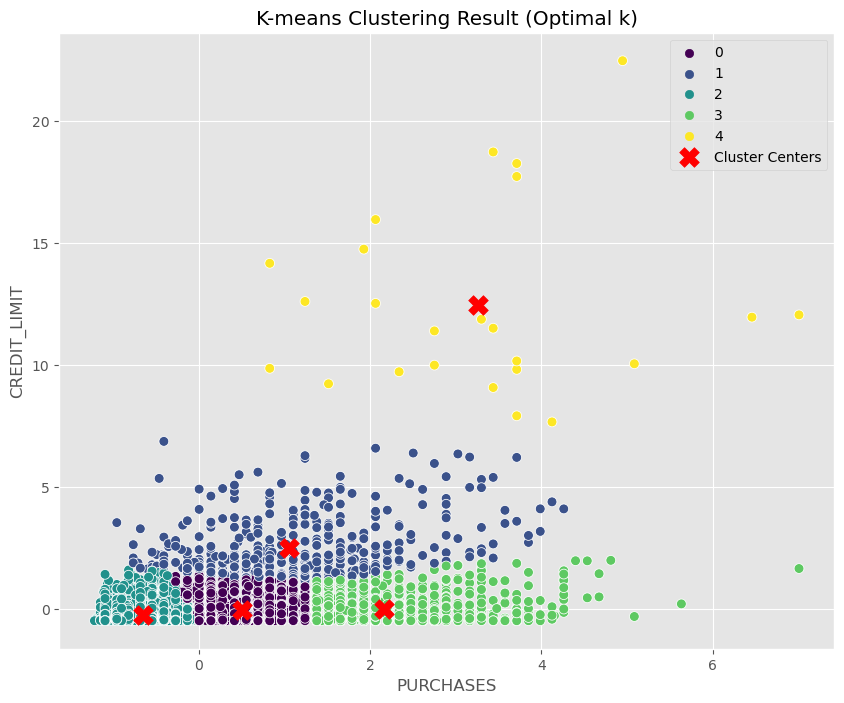

In [204]:
optimal_k = 5

# Re-run KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels_optimal = kmeans_optimal.fit_predict(X_scaled)


# Scatter plot using seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels_optimal, palette='viridis', s=50)
plt.title('K-means Clustering Result (Optimal k)')
plt.xlabel('PURCHASES')
plt.ylabel('CREDIT_LIMIT')
plt.legend(title='Cluster')

# Add cluster centers
plt.scatter(kmeans_optimal.cluster_centers_[:, 0], kmeans_optimal.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Cluster Centers')
plt.legend()

plt.show()



# Kmeans Cluster Interpretation
* Customers in green: Customers that seem to make high purchases of value above their credit limit. We can call them the extravagants.
* Customers in purple: Customers that seem to make average purchases of value below or above above their credit limit.
* Customers in yellow: Customers that seem to make low purchases of value that way below their credit limit. We can call them the cheap ones.
* Customers in blue: Customers that seem to make low purchases of value below or within their credit limit.
* Customers in light green: Customers that seem to make low purchases of value below their credit limit. They are careful customers.


# Professional Report Based on Findings:
# Introduction:
Our clustering analysis aimed to identify distinct customer segments based on purchase behavior and credit limits. Through hierarchical clustering and Kmeans clustering, we uncovered five clusters, each exhibiting unique spending patterns.

Since both the plots for the hierarchical and Kmeans are relativley the same,  i will discuss the insights based on the  hierarchical plot and it's cluster segment by color

# Cluster Insights:

# Extravagant Customers (Green):
* Identified as high spenders making purchases above their credit limit.* 
Recommendation: Develop  premium credit card offerings with exclusive benefits and rewards to capitalize on their spending potential
* An Example of an exclusive benefit could be : "Waived or discounted annual fees for maintaining a premium relationship and Special loyalty bonuses for card renewal"..

# Average Spending Customers (Purple):
*
This group displays a mix of average purchesas above or below their credit limit
* .
Recommendation: Tailor marketing strategies to provide versatile and flexible credit card options that cater to various spending habiwits hin this segmnt.

# Cheap Ones (Yellow): 

* 
Customers in this cluster make low-value purchases, significantly below their credit lmit
* 
Recommendation: Design targeted promotions and incentives to attract these customers towards increasing their spending or utilizing additionalreditit fedieaturess..

# Ambiguous Cluster (Blue):

* Shows low-value purchases, both below and within their credit limit.
* Recommendation: Further investigation is warranted to understand the specific characteristics of this group. We need to Consider additional features or surveys for a more nuanced interpretation.

# Careful Customers (Light Green):

* This segment consists of customers making low purchases but staying within their credit limit.
* Recommendation: Recognize and reward responsible spending habits. Offer credit education resources and consider promoting credit limit increase opportunities.

<!-- # Handling Outliers (Implementing two methods)

Winsorizing the extreme outlier for the CASH_ADVANCE column, using the Box-Cox transformation method for  the BALANCE_FREQUENCY column (since it handles negative values better), and applying log transformation to positively skewed variables  -->

In [4]:
# from scipy.stats import kurtosis, shapiro

# # Assuming df is your DataFrame
# variables_to_assess = ['PURCHASES', 'PAYMENTS', 'CREDIT_LIMIT', 'BALANCE_FREQUENCY', 'CASH_ADVANCE']

# # Apply transformations
# # ...

# # Calculate kurtosis after transformations
# kurtosis_after = df[variables_to_assess].kurtosis()

# # Perform Shapiro-Wilk normality test
# normality_test_after = df[variables_to_assess].apply(lambda x: shapiro(x)[1])

# # Print results
# print("Kurtosis After:", kurtosis_after)
# print("Normality Test P-Values After:", normality_test_after)
